# Imported Libraries

In [0]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import imutils
import pickle

In [0]:
#!pip install utils

#Calibration of Camera

##Supporting class for calibration


In [0]:
class ChessBoard:

  def __init__(self, test_number, test_file, x_boxes, y_boxes):
    self.test_number = test_number
    self.test_file = test_file
    self.x_boxes, self.y_boxes = x_boxes, y_boxes
    self.chess_matrix = (self.x_boxes, self.y_boxes)  # chess board variables initialization 

    read_img = mpimg.imread(self.test_file)
    grey_img = cv2.cvtColor(read_img, cv2.COLOR_RGB2GRAY)  # read file and grayscale it
    
    self.rows, self.col, self.channels = read_img.shape   #set dimensions according to orginal pictures
    self.dimensions = (self.rows, self.col)

    self.has_corners, self.corners = cv2.findChessboardCorners(grey_img,self.chess_matrix, None) # get corners using cv2 function
    self.chessboard_points = self.get_points()
    self.matrix, self.distortion, self.can_undistort = None, None, False
  
  def get_points(self):
    number_of_points = self.x_boxes * self.y_boxes
    points = np.zeros((number_of_points, 3), np.float32)
    points[:, :2] = np.mgrid[0:self.x_boxes, 0:self.y_boxes].T.reshape(-1, 2)
    return points

  # remove if not used  
  def image(self):
    read_img = mpimg.imread(self.test_file)
    return read_img

  def image_with_corners(self):
    ''' if this image doesn't have calculated corners, return raw image '''
    read_img = mpimg.imread(self.test_file)
    if self.has_corners:
      cv2.drawChessboardCorners(read_img, self.chess_matrix, self.corners, self.has_corners)
    return read_img

  def undistorted_image(self):
    '''if camera parameters is not initialized, return None '''
    read_img = None
    if self.can_undistort:
      read_img = mpimg.imread(self.test_file)
      read_img = cv2.undistort(read_img, self.matrix, self.distortion, None, self.matrix)
    return read_img
  
  def load_undistort_params(self, camera_matrix, distortion):
    self.distortion = distortion
    self.matrix = camera_matrix
    self.can_undistort = True

In [0]:
#initializing chessboards

chessboards = []
path = "4.jpeg"

for n in range(20):
  # add path for 20 different angles of the chessboard here
  chessboard = ChessBoard(test_number=n, test_file = path, x_boxes=9, y_boxes=6)
  chessboards.append(chessboard)

print("done")


done


In [0]:
# finding calibration parameters

points, corners = [], [],  #list for point and corners
shape = chessboards[0].dimensions

for chessboard in chessboards:
  if chessboard.has_corners:
    points.append(chessboard.object_points)
    corners.append(chessboard.corners)

# will work with actual chessboard pics
r, matrix, dist_coef, rv, tv = cv2.calibrateCamera(points, corners, shape, None, None)


In [0]:
# store calibration parameters for later

calibration_parameters = {"camera_matrix": matrix, "dist_coef": dist_coef}
pickle.dump(calibration_parameters, open("calibration_parameters.p", "wb"))

In [0]:
# get an undistorted picture\

for chessboard in chessboards:
  chessboard.load_undistort_params(calibration_matrix = matrix, distortion = dist_coef)

In [0]:
#save imgs

for chessboard in chessboards:
  if chessboard.has_corners:
    save_image(chassboard.image_with_corners, "corners", chessboard.test_number)
  
  if chessboard.can_undistort:
    save_image(chessboard.undistorted_image(), "undistortedboard", chessboard.test_number)

# Perspective Transformation

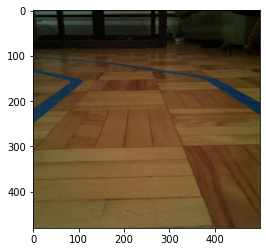

In [2]:
IMAGE_H = 480
IMAGE_W = 360

img = mpimg.imread("1.jpeg")
src = np.float32([[0, 100], [500, 100], [500, 300], [0, 300]])
dst = np.array([[0, img.shape[0]], [0, 0], [500, 0], [500, img.shape[0]]], np.float32)
def perspTransform(src, dst):
  M = cv2.getPerspectiveTransform(src, dst) # The transformation matrix
  Minv = cv2.getPerspectiveTransform(dst, src) # Inverse transformation

  return (M, Minv)

(M, Minv) = perspTransform(src, dst)
plt.imshow(img, cmap='gray')
plt.show()

#Warp Perspective

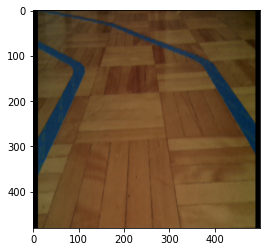

In [3]:
result = cv2.warpPerspective(img, M,(500,480), flags=cv2.INTER_LINEAR)
rotated = imutils.rotate(result, 270)
edges = cv2.Canny(rotated, 20,100)
plt.imshow(rotated, cmap='gray')
plt.show()


#Crop Image

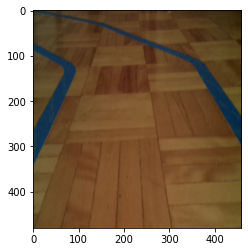

In [4]:
cropped_image = rotated[0:480, 20:480]
plt.imshow(cropped_image, cmap='gray')
plt.show()

edges = cv2.Canny(cropped_image, 10,100)

#Draw corners of trapazoid to be extracted 

In [0]:
#cv2.circle(img, (120, 150), 10, (0,0,255), -1)
#cv2.circle(img, (420, 150), 10, (0,0,255), -1)
#cv2.circle(img, (600, 250), 10, (0,0,255), -1)
#cv2.circle(img, (-100, 250), 10, (0,0,255), -1)

#Show orginal images with trapazoid that is being extracted and the transformed image

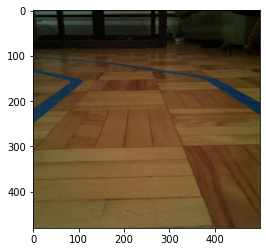

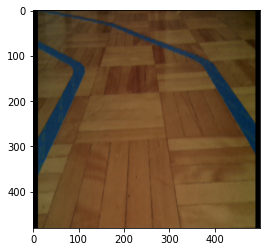

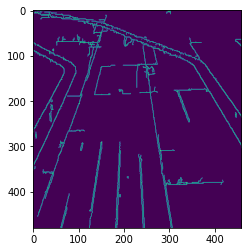

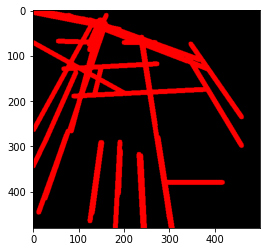

In [5]:
plt.imshow(img)
plt.show()
plt.imshow(rotated)
plt.show()
plt.imshow(edges)
plt.show()

lines = cv2.HoughLinesP(edges, 2,np.pi/180,
                        100,
                        np.array([]),
                        minLineLength=40,
                        maxLineGap=50)
line_img = np.zeros_like(img)

def draw_lines(img, lines):
    if lines is not None:
      for line in lines:
        x1,y1,x2,y2 =  line.reshape(4)
        cv2.line(line_img, (x1, y1), (x2,y2), (255, 0, 0), 10)
    return line_img
 
line_img = draw_lines(line_img, lines)
plt.imshow(line_img)
plt.show()

#height = img.shape[0]
#width = img.shape[1]
#print(height, width)    


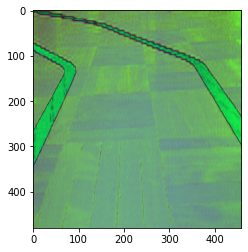

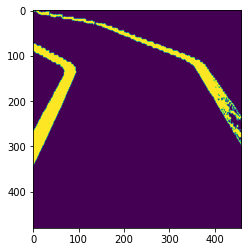

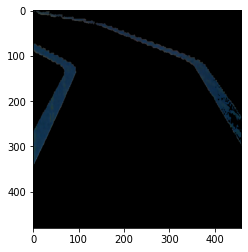

In [6]:
#img = cv2.imread('shuttle.jpg')   # you can read in images with opencv
img_hsv = cv2.cvtColor(cropped_image, cv2.COLOR_BGR2HSV)

lower_blue = np.array([10,0,50]) #change values here. not good
upper_blue = np.array([70,255,255])

#lower_blue = np.array([130,0,0]) #change values here. not good
#upper_blue = np.array([180,255,255])

mask = cv2.inRange(cropped_image, lower_blue, upper_blue)
res = cv2.bitwise_and(cropped_image, cropped_image, mask = mask)
plt.imshow(img_hsv, cmap='gray') 
plt.show()
plt.imshow(mask)  
plt.show()
plt.imshow(res)  
plt.show()
    

#Drawing a Histogram

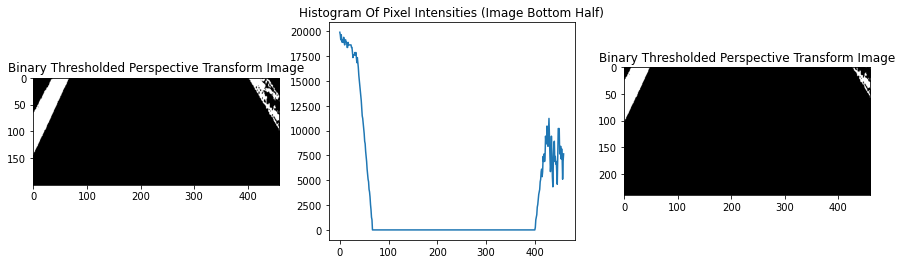

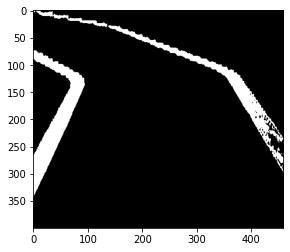

In [7]:
crop_mask = mask[0:400, 0:480]
histogram = np.sum(crop_mask[crop_mask.shape[0]//2:, :], axis=0)
histogram2 = np.sum(crop_mask[crop_mask.shape[0]//2:,:], axis=0)


fig, ax = plt.subplots(1, 3, figsize=(15,4))
ax[0].imshow(crop_mask[crop_mask.shape[0]//2:,:], cmap='gray')
#ax[0].axis("off")
ax[0].set_title("Binary Thresholded Perspective Transform Image")

ax[1].plot(histogram)
ax[1].set_title("Histogram Of Pixel Intensities (Image Bottom Half)")

ax[2].imshow(mask[edges.shape[0]//2:,:], cmap='gray')
#ax[2].axis("off")
ax[2].set_title("Binary Thresholded Perspective Transform Image")
plt.show()


plt.imshow(crop_mask, cmap='gray')
plt.show()

# Done Getting Histogram

In [0]:
import math

from collections import deque

def create_queue(length = 10):
    return deque(maxlen=length)


class LaneLine:
    def __init__(self):
        
        self.polynomial_coeff = None
        self.line_fit_x = None
        self.non_zero_x = []
        self.non_zero_y = []
        self.windows = []

class LaneLineHistory:
    def __init__(self, queue_depth=2, test_points=[50, 300, 500, 700], poly_max_deviation_distance=150):
        self.lane_lines = create_queue(queue_depth)
        self.smoothed_poly = None
        self.test_points = test_points
        self.poly_max_deviation_distance = poly_max_deviation_distance
    
    def append(self, lane_line, force=False):
        if len(self.lane_lines) == 0 or force:
            self.lane_lines.append(lane_line)
            self.get_smoothed_polynomial()
            return True
        
        test_y_smooth = np.asarray(list(map(lambda x: self.smoothed_poly[0] * x**2 + self.smoothed_poly[1] * x + self.smoothed_poly[2], self.test_points)))
        test_y_new = np.asarray(list(map(lambda x: lane_line.polynomial_coeff[0] * x**2 + lane_line.polynomial_coeff[1] * x + lane_line.polynomial_coeff[2], self.test_points)))
        
        dist = np.absolute(test_y_smooth - test_y_new)
        
        #dist = np.absolute(self.smoothed_poly - lane_line.polynomial_coeff)
        #dist_max = np.absolute(self.smoothed_poly * self.poly_max_deviation_distance)
        max_dist = dist[np.argmax(dist)]
        
        if max_dist > self.poly_max_deviation_distance:
            print("**** MAX DISTANCE BREACHED, STOPPING NOW ****")
            print("y_smooth={0} - y_new={1} - distance={2} - max-distance={3}".format(test_y_smooth, test_y_new, max_dist, self.poly_max_deviation_distance))
            return False
        
        self.lane_lines.append(lane_line)
        self.get_smoothed_polynomial()
        
        return True
    
    def get_smoothed_polynomial(self):
        all_coeffs = np.asarray(list(map(lambda lane_line: lane_line.polynomial_coeff, self.lane_lines)))
        self.smoothed_poly = np.mean(all_coeffs, axis=0)
        
        return self.smoothed_poly

# We know where to start the sliding window algo

In [0]:
class LineDetector:

    def __init__(self, objpts, imgpts, src, dst, sliding_windows_per_line, 
                 sliding_window_half_width, sliding_window_recenter_thres, 
                 small_img_size=(256, 144), small_img_x_offset=20, small_img_y_offset=10,
                 img_dimensions=(720, 1280), lane_width_px=800, 
                 lane_center_px_psp=600, real_world_lane_size_cm=(32, 27.5)):
        self.objpts = objpts
        self.imgpts = imgpts
        (self.M_psp, self.M_inv_psp) = perspTransform(src, dst)

        self.sliding_windows_per_line = sliding_windows_per_line
        self.sliding_window_half_width = sliding_window_half_width
        self.sliding_window_recenter_thres = sliding_window_recenter_thres
        
        self.small_img_size = small_img_size
        self.small_img_x_offset = small_img_x_offset
        self.small_img_y_offset = small_img_y_offset
        
        self.img_dimensions = img_dimensions
        self.lane_width_px = lane_width_px
        self.lane_center_px_psp = lane_center_px_psp 
        self.real_world_lane_size_cm = real_world_lane_size_cm

        # We can pre-compute some data here
        self.ym_per_px = self.real_world_lane_size_cm[0] / self.img_dimensions[0]
        self.xm_per_px = self.real_world_lane_size_cm[1] / self.lane_width_px
        self.ploty = np.linspace(0, self.img_dimensions[0] - 1, self.img_dimensions[0])
        
        self.previous_left_lane_line = None
        self.previous_right_lane_line = None
        
        self.previous_left_lane_lines = LaneLineHistory()
        self.previous_right_lane_lines = LaneLineHistory()

        self.total_img_count = 0  

    def processImage(self, image):
      ll, rl, mid_fit = self.compute_lane_lines(image)
      
      print(ll)#.line_fit_x, rl.line_fit_x)
      if ll == 0  and rl == 0:
        print("needs to turn")
        return mid_fit, ll.line_fit_x, rl. line_fit_x
      drawn_lines = self.draw_lane_lines(image, ll, rl)
      plt.imshow(image[image.shape[0]//2:,:], cmap = 'gray')
      plt.show()  
      plt.imshow(drawn_lines, cmap = 'gray')
      plt.show()

      ploty = np.linspace(0, image.shape[0] - 1, image.shape[0] )
      mid_fitx = (mid_fit[0] * ploty**2 + mid_fit[1] * ploty + mid_fit[2])
      pts_mid = np.dstack((mid_fitx, ploty)).astype(np.int32)
      cv2.circle(image, (230, 250), 10, (255,255,255), -1)
      i = cv2.polylines(image, pts_mid, False,  (255, 140,0), 5)
      plt.imshow(i, cmap = 'gray')
      plt.show()
      print(mid_fit)

      return mid_fit, ll.polynomial_coeff, rl.polynomial_coeff
    
    def draw_lane_lines(self, warped_img, left_line, right_line):
        """
        Returns an image where the computed lane lines have been drawn on top of the original warped binary image
        """
        # Create an output image with 3 colors (RGB) from the binary warped image to draw on and  visualize the result
          
        out_img = np.dstack((warped_img, warped_img, warped_img))*255
        
        # Now draw the lines
        ploty = np.linspace(0, warped_img.shape[0] - 1, warped_img.shape[0])
        pts_left = np.dstack((left_line.line_fit_x, ploty)).astype(np.int32)
        pts_right = np.dstack((right_line.line_fit_x, ploty)).astype(np.int32)

        cv2.polylines(out_img, pts_left, False,  (255, 140,0), 5)
        cv2.polylines(out_img, pts_right, False, (255, 140,0), 5)
        
        if not (left_line.line_fit_x[0] == 0 and left_line.line_fit_x[1] == 0 and left_line.line_fit_x[2] == 0):
          for low_pt, high_pt in left_line.windows:
            cv2.rectangle(out_img, low_pt, high_pt, (0, 255, 0), 3)
        else:
          print("not plotting left windows")

        if not (right_line.line_fit_x[0] == 0 and right_line.line_fit_x[1] == 0 and right_line.line_fit_x[2] == 0):
          for low_pt, high_pt in right_line.windows:            
              cv2.rectangle(out_img, low_pt, high_pt, (0, 255, 0), 3)           
        else:
          print("not plotting right windows")
        return out_img   

    def compute_lane_lines(self, warped_img):
        """
        Returns the tuple (left_lane_line, right_lane_line) which represents respectively the LaneLine instances for
        the computed left and right lanes, for the supplied binary warped image
        """

        # Take a histogram of the bottom half of the image, summing pixel values column wise 
        histogram = np.sum(warped_img[warped_img.shape[0]//2:,:], axis=0)
        
        # Find the peak of the left and right halves of the histogram
        # These will be the starting point for the left and right lines 
        midpoint = np.int(histogram.shape[0]//2)
        leftx_base = np.argmax(histogram[:midpoint])
        rightx_base = np.argmax(histogram[midpoint:]) + midpoint # don't forget to offset by midpoint!
        

        # Set height of windows
        window_height = np.int(warped_img.shape[0]//self.sliding_windows_per_line)
        # Identify the x and y positions of all nonzero pixels in the image
        # NOTE: nonzero returns a tuple of arrays in y and x directions
        nonzero = warped_img.nonzero()
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        
        total_non_zeros = len(nonzeroy)
        non_zero_found_pct = 0.0
        one_line_detected = False
        
        # Current positions to be updated for each window
        leftx_current = leftx_base
        rightx_current = rightx_base    


        # Set the width of the windows +/- margin
        margin = self.sliding_window_half_width
        # Set minimum number of pixels found to recenter window
        minpix = self.sliding_window_recenter_thres
        # Create empty lists to receive left and right lane pixel indices
        left_lane_inds = []
        right_lane_inds = []
        
        # Our lane line objects we store the result of this computation
        left_line = LaneLine()
        right_line = LaneLine()
                        
        if self.previous_left_lane_line is not None and self.previous_right_lane_line is not None:
            # We have already computed the lane lines polynomials from a previous image
            left_lane_inds = ((nonzerox > (self.previous_left_lane_line.polynomial_coeff[0] * (nonzeroy**2) 
                                           + self.previous_left_lane_line.polynomial_coeff[1] * nonzeroy 
                                           + self.previous_left_lane_line.polynomial_coeff[2] - margin)) 
                              & (nonzerox < (self.previous_left_lane_line.polynomial_coeff[0] * (nonzeroy**2) 
                                            + self.previous_left_lane_line.polynomial_coeff[1] * nonzeroy 
                                            + self.previous_left_lane_line.polynomial_coeff[2] + margin))) 

            right_lane_inds = ((nonzerox > (self.previous_right_lane_line.polynomial_coeff[0] * (nonzeroy**2) 
                                           + self.previous_right_lane_line.polynomial_coeff[1] * nonzeroy 
                                           + self.previous_right_lane_line.polynomial_coeff[2] - margin)) 
                              & (nonzerox < (self.previous_right_lane_line.polynomial_coeff[0] * (nonzeroy**2) 
                                            + self.previous_right_lane_line.polynomial_coeff[1] * nonzeroy 
                                            + self.previous_right_lane_line.polynomial_coeff[2] + margin))) 
            
            non_zero_found_left = np.sum(left_lane_inds)
            non_zero_found_right = np.sum(right_lane_inds)
            non_zero_found_pct = (non_zero_found_left + non_zero_found_right) / total_non_zeros
           
            print("[Previous lane] Found pct={0}".format(non_zero_found_pct))
            #print(left_lane_inds)
        
        if non_zero_found_pct < 0.85:
            print("Non zeros found below thresholds, begining sliding window - pct={0}".format(non_zero_found_pct))
            left_lane_inds = []
            right_lane_inds = []

            # Step through the windows one by one
            for window in range(self.sliding_windows_per_line):
                # Identify window boundaries in x and y (and right and left)
                # We are moving our windows from the bottom to the top of the screen (highest to lowest y value)
                win_y_low = warped_img.shape[0] - (window + 1)* window_height
                win_y_high = warped_img.shape[0] - window * window_height

                # Defining our window's coverage in the horizontal (i.e. x) direction 
                # Notice that the window's width is twice the margin
                win_xleft_low = leftx_current - margin
                win_xleft_high = leftx_current + margin
                win_xright_low = rightx_current - margin
                win_xright_high = rightx_current + margin
     
                left_line.windows.append([(win_xleft_low,win_y_low),(win_xleft_high,win_y_high)])
                right_line.windows.append([(win_xright_low,win_y_low),(win_xright_high,win_y_high)])

                # Super crytic and hard to understand...
                # Basically nonzerox and nonzeroy have the same size and any nonzero pixel is identified by
                # (nonzeroy[i],nonzerox[i]), therefore we just return the i indices within the window that are nonzero
                # and can then index into nonzeroy and nonzerox to find the ACTUAL pixel coordinates that are not zero
                good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
                (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
                good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
                (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
                            
                # Append these indices to the lists
                left_lane_inds.append(good_left_inds)
                right_lane_inds.append(good_right_inds)

                # If you found > minpix pixels, recenter next window on their mean position
                if len(good_left_inds) > minpix:
                    leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
                if len(good_right_inds) > minpix:        
                    rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

            # Concatenate the arrays of indices since we now have a list of multiple arrays (e.g. ([1,3,6],[8,5,2]))
            # We want to create a single array with elements from all those lists (e.g. [1,3,6,8,5,2])
            # These are the indices that are non zero in our sliding windows
            left_lane_inds = np.concatenate(left_lane_inds)
            right_lane_inds = np.concatenate(right_lane_inds)

            #print('length right side lane: ' + str(right_lane_inds))
            
            non_zero_found_left = np.sum(left_lane_inds)
            non_zero_found_right = np.sum(right_lane_inds)
            non_zero_found_pct = (non_zero_found_left + non_zero_found_right) / total_non_zeros
           
            print("[Sliding windows] Found pct={0}".format(non_zero_found_pct))
            
    
        # Extract left and right line pixel positions
        leftx = nonzerox[left_lane_inds]
        lefty = nonzeroy[left_lane_inds] 
        rightx = nonzerox[right_lane_inds]
        righty = nonzeroy[right_lane_inds] 
        
        #print("[LEFT] Number of hot pixels={0}".format(len(leftx)))
        #print("[RIGHT] Number of hot pixels={0}".format(len(rightx)))
        # Fit a second order polynomial to each
        #print(leftx, rightx)
        if len(leftx) == 0 and len(rightx)==0:
          print("empty list no lines. start turning in a circle")
          return (0, 0, 0)
          
        left_fit = np.polyfit(lefty, leftx, 2)
        right_fit = np.polyfit(righty, rightx, 2)
        if left_fit[0] == right_fit[0] and left_fit[1] == right_fit[1] and left_fit[2] == right_fit[2]:
          one_line_detected = True
          print("only one line create function here")
        mid_fit = (left_fit + right_fit)/2
        print("Poly left {0}".format(left_fit))
        print("Poly right {0}".format(right_fit))
        print("Poly mid {0}".format(mid_fit))
        if one_line_detected:
          left_fit[0] = 0
          left_fit[1] = 0
          left_fit[2] = 0
          new_leftx = []
          for item in leftx:
            new_leftx.append(0)
          leftx = new_leftx
          left_fit[0:2] = 0
          print("left line is positive hence needs to turn right")
         
        left_line.polynomial_coeff = left_fit
        right_line.polynomial_coeff = right_fit
        
        if not self.previous_left_lane_lines.append(left_line):
            left_fit = self.previous_left_lane_lines.get_smoothed_polynomial()
            left_line.polynomial_coeff = left_fit
            self.previous_left_lane_lines.append(left_line, force=True)
            print("**** REVISED Poly left {0}".format(left_fit))            
        #else:
            #left_fit = self.previous_left_lane_lines.get_smoothed_polynomial()
            #left_line.polynomial_coeff = left_fit


        if not self.previous_right_lane_lines.append(right_line):
            right_fit = self.previous_right_lane_lines.get_smoothed_polynomial()
            right_line.polynomial_coeff = right_fit
            self.previous_right_lane_lines.append(right_line, force=True)
            print("**** REVISED Poly right {0}".format(right_fit))
        #else:
            #right_fit = self.previous_right_lane_lines.get_smoothed_polynomial()
            #right_line.polynomial_coeff = right_fit


        # Generate x and y values for plotting
        ploty = np.linspace(0, warped_img.shape[0] - 1, warped_img.shape[0] )
        left_fitx = left_fit[0] * ploty**2 + left_fit[1] * ploty + left_fit[2]
        right_fitx = right_fit[0] * ploty**2 + right_fit[1] * ploty + right_fit[2]
        mid_fitx = mid_fit[0] * ploty**2 + mid_fit[1] * ploty + mid_fit[2]
        
        left_line.polynomial_coeff = left_fit
        left_line.line_fit_x = left_fitx
        left_line.non_zero_x = leftx  
        left_line.non_zero_y = lefty

        right_line.polynomial_coeff = right_fit
        right_line.line_fit_x = right_fitx
        right_line.non_zero_x = rightx
        right_line.non_zero_y = righty

        
        return (left_line, right_line, mid_fit)




#Testing Sliding Window algo here

Non zeros found below thresholds, begining sliding window - pct=0.0
[Sliding windows] Found pct=7220.839839145809
Poly left [-1.63079046e-03  4.01506780e-01  3.44102739e+01]
Poly right [-7.31639725e-03  3.39762249e+00  4.37556773e+01]
Poly mid [-4.47359385e-03  1.89956464e+00  3.90829756e+01]


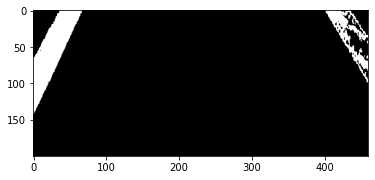

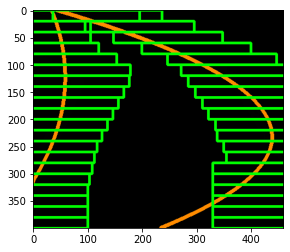

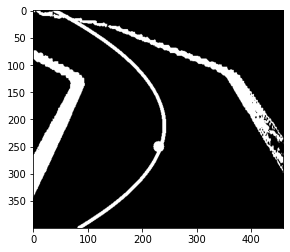

[-4.47359385e-03  1.89956464e+00  3.90829756e+01]
[-4.47359385e-03  1.89956464e+00  3.90829756e+01] [-1.63079046e-03  4.01506780e-01  3.44102739e+01] [-7.31639725e-03  3.39762249e+00  4.37556773e+01]


In [10]:
opts = 0
ipts = 0
algo = LineDetector(opts, ipts, src, dst, 20, 100, 50)
mid_fit, left_l, right_l = algo.processImage(crop_mask)
print(mid_fit, left_l, right_l)


# Function that defines speed and turning radius required to achieve the curve depicted by the polynomial.

#radius = 9cm
# turning angle is 90 degrees


In [15]:
forward = 1
right = 2
left = 3
backward = 4
stop = 5
terminate_program = 7

def followTrajectory(mid, left, right):
  if mid.all() == 0 and left.all() == 0 and right.all() == 0: # logic to simply turn around in circles
    print("here1")
    send_pkt(right, 60, 1)
  if left.all() == 0:
    send_pkt(left, 60, 0.7)
    print("turn left")
  if right.all()==0:
    send_pkt(right, 60, 0.7)
    print("turn right") 
  if left.all() != 0 and right.all() != 0:
    send_pkt(forward, 40)
    print("forward")

def send_pkt(direction, pwm):
  print(direction, pwm)
  #print("ok")
followTrajectory(mid_fit, left_l, right_l)



1 40
forward


http://faculty.washington.edu/cfolson/papers/pdf/cviu99.pdf
https://towardsdatascience.com/deeppicar-part-4-lane-following-via-opencv-737dd9e47c96
https://www.hackster.io/kemfic/curved-lane-detection-34f771

